## Parameter Selection for Temporal Mapper

On this page, we will describe the critical parameters of `temporalmapper.TemporalMapper`, and give advice on how to select them for your data. 

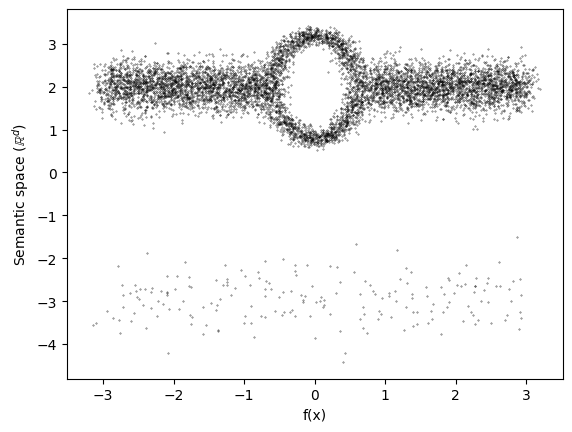

In [1]:
import temporalmapper as tm
import temporalmapper.utilities_ as tmutils
import temporalmapper.weighted_clustering as tmwc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io
from sklearn.cluster import DBSCAN
import datamapplot as dmp

demo_data_file = requests.get("https://github.com/TutteInstitute/temporal-mapper/raw/docs/docs/data/genus1_demo.npy")
data_time = np.load(io.BytesIO(demo_data_file.content)) 
data_unsort = data_time[:,1].T
time_unsort = data_time[:,0].T
sorted_indices = np.argsort(time_unsort)
data = data_unsort[sorted_indices]
time = time_unsort[sorted_indices]
fig, ax = plt.subplots(1,1)
ax.scatter(time,data,s=0.1,c='k',alpha=0.8)
ax.set_ylabel("Semantic space ($\mathbb{R}^d$)")
ax.set_xlabel("f(x)")
plt.show()

### Number of Checkpoints: `N_checkpoints`

The parameter `N_checkpoints` has the greatest impact on the output of Mapper, so it is important to make a reasonable choice.

If we had infintely many data points, then the theory tells us that there is some maximum `M` such that for `N_checkpoints > M`, the Mapper graph will capture all the topological features. For this reason, we want to take `N_checkpoints` large. However with finite data, as `N_checkpoints` is increased, the output graph will become more and more disconnected. This defines the following trade-off:

As `N_checkpoints`$ \to$∞, the **amount of features captured increases** and the **amount of discretization artifacts increases**.

To avoid having many artifacts, it is important that each time interval has enough points for the clustering to be reasonable. This gives a heuristic; if you need at least $s$ points to trust the clustering algorithm, and you have $n$ samples, then you can take `N_checkpoints` $\approxeq n/s$.

For DBMapper, which is the default for `tm.TemporalMapper`, the clustering intervals get strictly larger than in default Mapper, and hence you can afford to choose a larger `N_checkpoints` then you would for Mapper.

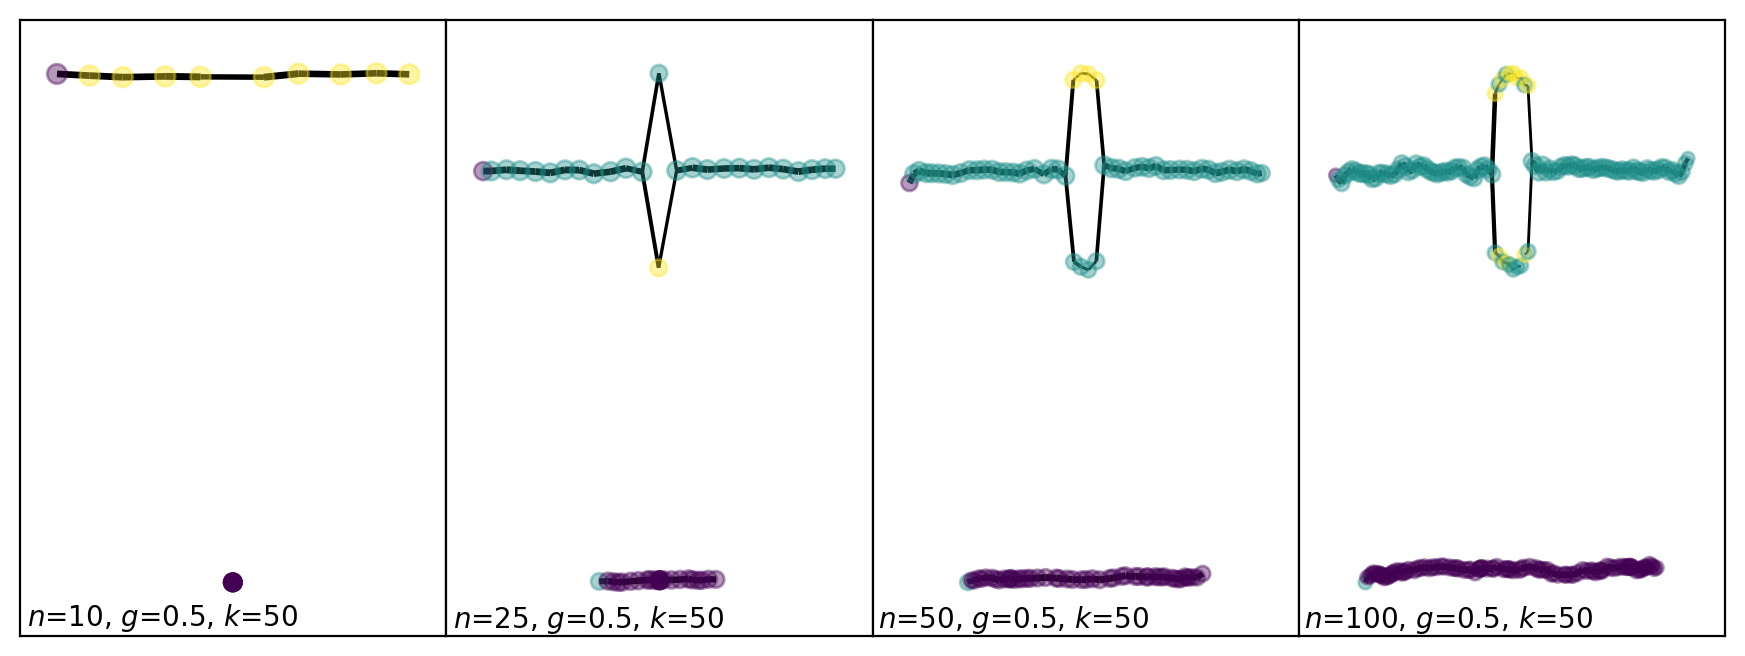

In [11]:

checkpoint_numbers = [10,25,50,100]

fig, axes = plt.subplots(1,len(checkpoint_numbers))
fig.set_figwidth(11)
fig.set_figheight(4)
fig.dpi = 200
axes = axes.reshape(len(checkpoint_numbers))
clusterer = DBSCAN()
j = 0
for k in range(len(checkpoint_numbers)):
    TM = tm.TemporalMapper(
        time,
        data,
        clusterer,
        N_checkpoints = checkpoint_numbers[k],
        neighbours = 50,
        kernel=tmwc.square,
    )
    TM.fit()
    tmutils.time_semantic_plot(TM, data, ax=axes[k])
    xmin,xmax=axes[k].get_xlim()
    ymin,ymax=axes[k].get_ylim()
    axes[k].text(xmin+0.1,ymin+0.1,fr'$n$={TM.N_checkpoints}, $g$={TM.g}, $k$={50}')
    if k%4==3:
        j+=1
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


### Choice of Open Cover: `slice_method`

The next most impactful choice is the method used to choose the time-intervals used in Mapper. Temporal Mapper includes two natural choices, `slice_method='time'` and `slice_method='data'`. Using `time`, the intervals are evenly spaced in time, and using `data`, the intervals have even amounts of data in them. Using `time` is generally fine, but if your data is very unevenly distributed in time, then using `data` can provide more consistent results.

### Choice of Clustering Algorithm: `clusterer`

For the most part, your choice of clustering algorithm for Temporal-Mapper is informed by the same trade-offs as any clustering problem. For this purpose, the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/clustering.html) provides a good overview. However, there is one extra thing to note for Temporal Mapper: in Mapper, the clustering algorithm's purpose is to determine the number of connected components of each slice of the data. Therefore, it is epistemologically backwards to use a clustering algorithm that requires an a-priori choice of number of clusters, such as k-means. Instead, choose something like DBSCAN, which has variable number of clusters.

### Number of Nearest-Neighbours: `neighbours`
The parameter `neighbours`, or $k$, is the number of neighbours used in the approximation of the temporal density. As $k$ and the number of samples grows, the approximation improves. However, for finite sample sizes, increasing $k$ will average the temporal density as a function of the semantic-space co-ordinates; in the extreme, if $k>$ `n_samples`, the temporal density will be constant. Moreover, the $k$ nearest-neighbours computation is one of the computation bottlenecks in DBMapper, and therefore increasing $k$ has a noticable performance cost on large datasets.

If your dataset is large (100k+), then we suggest taking $k$ as large as your computational budget allows. If your dataset is very small, then taking large $k$ is likely to over-average the temporal density. In this case, start with $k$ around 50-100.

### Temporal Kernel: `kernel`

The choice of temporal kernel has two effects on the output of temporal mapper. The kernel defines weights for the samples, which are passed to the clustering algorithm, and which are used to weigh edges of the output graph.

If you are using a clustering algorithm which does not support sample weights, and you are not using weighted edges on the Mapper graph, then there is no mathematical advantage to using a non-square kernel; in this case set `kernel=tmwc.square`, for a minor performance improvement.